In [ ]:
##### 2D unet #####

In [2]:
# Import required libraries
from monai.utils import first, set_determinism
from monai.transforms import (
AsDiscrete,
AsDiscreted,
EnsureChannelFirstd,
Compose,
CropForegroundd,
LoadImaged,
Orientationd,
Spacingd,
Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

import torch
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob



import SimpleITK as sitk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")


root dir is: /scratch/6989076.1.ece/tmpjsr6ouv3


In [4]:
# Define paths to the folders containing images and masks
data_folder = "/projectnb/ec500kb/projects/Project_3/Maolin/Data/"
masks_folder = "/projectnb/ec500kb/projects/Project_3/Maolin/Data/"  # Same as the image folder

# Create empty lists to store image and mask data
image_dataset = []
left_mask_dataset = []
right_mask_dataset = []

TwoD_image_dataset = []
TwoD_mask_dataset = []

# Iterate through image files and import them
for images_folder in os.listdir(data_folder):
    if os.path.isdir(os.path.join(data_folder, images_folder)):
        print(images_folder)
        for filename in os.listdir(os.path.join(data_folder, images_folder)):
            if filename.endswith('.nrrd'):
                # Construct full path to the image file
                raw_img_path = os.path.join(data_folder, images_folder, filename)

                # Read in image
                raw_img_sitk = sitk.ReadImage(raw_img_path, sitk.sitkFloat32)
                # print(raw_img_sitk)
                # Convert the array
                raw_img_sitk_arr = sitk.GetArrayFromImage(raw_img_sitk)
                # print(raw_img_sitk_arr.shape[0])
                
                for s in range(raw_img_sitk_arr.shape[0]):
                    TwoD_image_dataset.append(raw_img_sitk_arr[s,:,:])
                    for side in ["left", "right"]:  # It is done this way so that I import 5 copies of each mask. since the same mask is used for each image volume
                        mask_filename = f"svr_{side}KidneyMask2.nii.gz"
                        mask_path = os.path.join(masks_folder, images_folder, mask_filename)

                        # Read in mask
                        raw_mask_sitk = sitk.ReadImage(mask_path, sitk.sitkFloat32)

                        # Convert the array
                        mask_arr = sitk.GetArrayFromImage(raw_mask_sitk)

                        if side == "left":
                            left_mask_dataset.append(mask_arr[0])
                        elif side == "right":
                            right_mask_dataset.append(mask_arr[0])
              
            # Add image data to list
                image_dataset.append(raw_img_sitk_arr)

                # Iterate through each mask file
                

# Convert lists to numpy arrays
image_dataset = np.array(image_dataset)
left_mask_dataset = np.array(left_mask_dataset)
right_mask_dataset = np.array(right_mask_dataset)

# Combine the left and right kidney masks into one mask
combined_masks = []

for i in range(len(left_mask_dataset)):
    combined_masks.append(left_mask_dataset[i] + right_mask_dataset[i])
    
combined_masks = np.array(combined_masks);




TwoD_image_dataset = np.array(TwoD_image_dataset)
TwoD_mask_dataset = np.array(combined_masks)

# Print the shapes to verify
# print("Image dataset shape:", image_dataset.shape)  # samples, slices, slice_x, slice_y
# print("Left Mask dataset shape:", left_mask_dataset.shape)
# print("Right Mask dataset shape:", right_mask_dataset.shape)
print("2d image dataset shape:", TwoD_image_dataset.shape)
print("2d mask dataset shape:", TwoD_mask_dataset.shape)



case7
case3
case4
case5
case8
case1
case2
case6
2d image dataset shape: (720, 128, 128)
2d mask dataset shape: (720, 128, 128)


In [5]:

num_samples = TwoD_image_dataset.shape[0]
num_subjects_test = 2     # number of subjects used for testing
num_subjects_val = 1      # number of subjects used for validation

# 8 participants
num_slices_test = num_subjects_test*90
num_slices_train = num_samples - num_slices_test

# Split the datasets into training, validation, and testing
X_train = TwoD_image_dataset[:num_slices_train] 
y_train = TwoD_mask_dataset[:num_slices_train]

X_test = TwoD_image_dataset[-num_slices_test:] 
y_test = TwoD_mask_dataset[-num_slices_test:]


# X_train, X_test, y_train, y_test = train_test_split(TwoD_image_dataset, TwoD_mask_dataset, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nX_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (540, 128, 128)
y_train shape: (540, 128, 128)

X_test shape: (180, 128, 128)
y_test shape: (180, 128, 128)


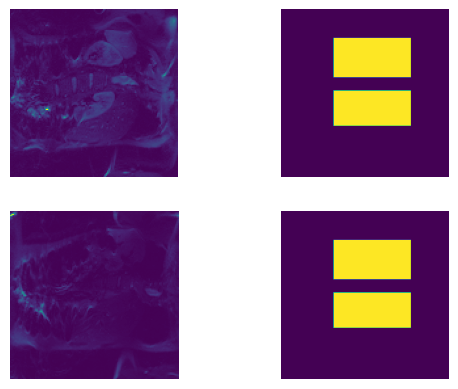

In [6]:
# Visualize some of the dataset
img_number = 5
slice = 9

image = X_train[slice]
mask = y_train[slice]

plt.subplot(2,2,1)
plt.imshow(image)
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(mask)
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(X_train[slice-5])
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(y_train[slice-5])
plt.axis("off")

plt.show()

In [7]:
from monai.transforms import Randomizable, Rotate
import scipy.ndimage
import numpy as np

image_data = X_train
mask_data = y_train

angles = [0, 90, 180, 270]
scaling_factor = np.arange(0.5,1.3,0.1)

augmented_images = np.empty_like(image_data)
augmented_masks = np.empty_like(mask_data)

rotated_images = np.empty_like(image_data)
rotated_masks = np.empty_like(mask_data)

## rotate images and masks 

# Iterate through each image
for i in range(image_data.shape[0]):
    # print(f"image {i}")
    
    # augmentation values for given mask/image pair
    angle = np.random.choice(angles)
    scale = np.random.choice(scaling_factor)
   
    rotated_mask = scipy.ndimage.rotate(mask_data[i], angle, reshape=False)
    rotated_masks[i] = rotated_mask
    
    rotated_image = scipy.ndimage.rotate(image_data[i], angle, reshape=False)
    rotated_images[i] = rotated_image*scale
        
print(rotated_images.shape)
print(rotated_masks.shape)



## apply gaussian filter to training images
blurred_images = np.empty_like(image_data)

def apply_blur(image):
    sigmas = [1,2,3]
    # Randomly-ish apply the filter or not
    if np.random.rand() < 0.7:
        sigma = np.random.choice(sigmas) 
        filtered_image = scipy.ndimage.gaussian_filter(image, sigma=sigma)
        return filtered_image
    else:
        return image

# Apply Gaussian filter to each rotated image with set probability
for i in range(rotated_images.shape[0]):
        blurred_images[i] = apply_blur(rotated_images[i])

# Ensure the shapes of rotated_data and rotated_masks remain the same
print(blurred_images.shape)






(540, 128, 128)
(540, 128, 128)
(540, 128, 128)


In [8]:
# Concatenate the augmented images and masks with the original training set data
X_train_plus = np.concatenate((image_data, rotated_images, blurred_images), axis=0)
y_train_plus = np.concatenate((mask_data, rotated_masks, rotated_masks), axis=0)

print("Original training data shape:", X_train.shape)
print("Bolstered training data shape:", X_train_plus.shape)
print("Original training mask shape:", y_train.shape)
print("Bolstered training mask shape:", y_train_plus.shape)

Original training data shape: (540, 128, 128)
Bolstered training data shape: (1620, 128, 128)
Original training mask shape: (540, 128, 128)
Bolstered training mask shape: (1620, 128, 128)


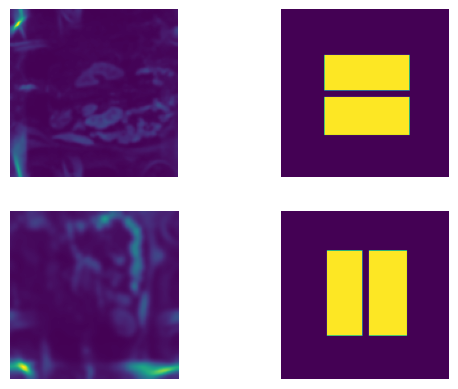

In [9]:
# Visualize some of the dataset AFTER TRANSFORMS
img_number = 1228

image = X_train_plus[img_number]
mask = y_train_plus[img_number]

plt.subplot(2,2,1)
plt.imshow(image)
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(mask)
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(X_train_plus[img_number-3])
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(y_train_plus[img_number-3])
plt.axis("off")

plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from monai.losses import DiceLoss

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the UNet model
class MyUNet(nn.Module):
    def __init__(self):
        super(MyUNet, self).__init__()
        self.unet = UNet(
            spatial_dims=2,  # Set spatial dimensions to 2 for 2D data
            in_channels=1,  # Input volume with 18 channels
            out_channels=1,  # Single channel output mask
            channels=(16, 32, 64, 128, 256), #, 256 # Depth of 5 - Look at why 256 is here
            strides=(2, 2, 2,2),
            num_res_units=2,  # Number of residual units
            dropout=0.1  # Optional dropout
        )

    def forward(self, x):
        return self.unet(x)

# Initialize the model and move it to the GPU
model = MyUNet().to(device)

# Define Dice Loss
criterion = DiceLoss(sigmoid=True)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Convert numpy arrays to PyTorch tensors and move them to GPU
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1).to(device)  # Permute to have correct dimension order
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)

# X_val_tensor = torch.FloatTensor(X_val).unsqueeze(1).to(device)
# y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to(device)


print(X_train_tensor.shape)
print(y_train_tensor.shape)

print(X_val_tensor.shape)
print(y_val_tensor.shape)



Using device: cuda
torch.Size([540, 1, 128, 128])
torch.Size([540, 1, 128, 128])


NameError: name 'X_val_tensor' is not defined

In [12]:
from monai.metrics import DiceMetric
dice_metric = DiceMetric(include_background=True)
val_losses = []
val_dice_scores = []

def validate(model, criterion, X_val_tensor, y_val_tensor):
    model.eval()  
    with torch.no_grad():
        outputs = model(X_val_tensor)
        val_loss = criterion(outputs, y_val_tensor)
        val_losses.append(val_loss.item())
        # Compute the Dice score
        dice_metric(outputs, y_val_tensor)
        dice_score = dice_metric.aggregate().item()
        val_dice_scores.append(dice_score)
        print(f'Validation - Loss: {val_loss:.4f}')     #, Dice Score: {dice_score:.4f}')     ##### include but need threshold function



# TRAINING LOOP

losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    # Set the model to train mode
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor)
    
    # Compute the loss
    loss = criterion(outputs, y_train_tensor)
    losses.append(loss.item())
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        #validate(model,criterion,X_val_tensor,y_val_tensor)               # uncomment if validation working

Epoch [10/1000], Loss: 0.6660
Epoch [20/1000], Loss: 0.6628
Epoch [30/1000], Loss: 0.6576
Epoch [40/1000], Loss: 0.6509
Epoch [50/1000], Loss: 0.6450
Epoch [60/1000], Loss: 0.6407
Epoch [70/1000], Loss: 0.6369
Epoch [80/1000], Loss: 0.6322
Epoch [90/1000], Loss: 0.6240
Epoch [100/1000], Loss: 0.5997
Epoch [110/1000], Loss: 0.5634
Epoch [120/1000], Loss: 0.5143
Epoch [130/1000], Loss: 0.4684
Epoch [140/1000], Loss: 0.4361
Epoch [150/1000], Loss: 0.4126
Epoch [160/1000], Loss: 0.3950
Epoch [170/1000], Loss: 0.3805
Epoch [180/1000], Loss: 0.3676
Epoch [190/1000], Loss: 0.3550
Epoch [200/1000], Loss: 0.3428
Epoch [210/1000], Loss: 0.3314
Epoch [220/1000], Loss: 0.3193
Epoch [230/1000], Loss: 0.3075
Epoch [240/1000], Loss: 0.2961
Epoch [250/1000], Loss: 0.2843
Epoch [260/1000], Loss: 0.2726
Epoch [270/1000], Loss: 0.2611
Epoch [280/1000], Loss: 0.2515
Epoch [290/1000], Loss: 0.2394
Epoch [300/1000], Loss: 0.2281
Epoch [310/1000], Loss: 0.2173
Epoch [320/1000], Loss: 0.2068
Epoch [330/1000],

Test Loss: 0.1616


Text(0, 0.5, 'Loss')

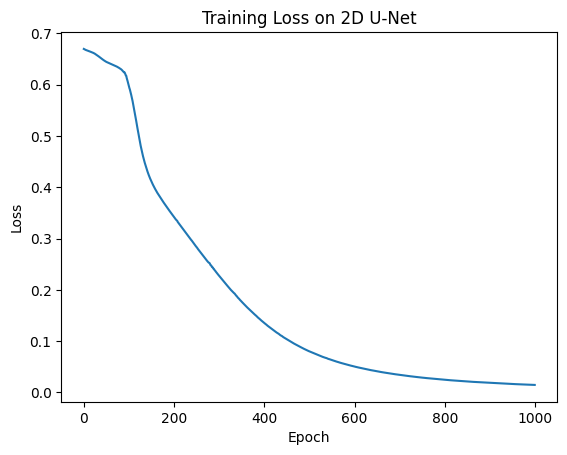

In [13]:
# Evaluate the model on the test set if needed
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1).to(device) 
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

test_masks = []

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    test_loss = criterion(outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    test_masks = [thing.cpu() for thing in outputs]

    
plt.plot(np.arange(len(losses)),losses)
plt.title("Training Loss on 2D U-Net")
plt.xlabel("Epoch")
plt.ylabel("Loss")


In [14]:
thresholded_masks = []

for mask in test_masks:
    # Calculate intensity range
    min_intensity = torch.min(mask)
    max_intensity = torch.max(mask)
    intensity_range = max_intensity - min_intensity
    
    # Calculate 50% mark
    threshold = min_intensity + 0.5 * intensity_range
    
    # Threshold the mask
    thresholded_mask = torch.where(mask >= threshold, torch.tensor(1), torch.tensor(0))
    
    # Append the thresholded mask to the list
    thresholded_masks.append(thresholded_mask)
    
    

thresholded_masks_train = []

for mask in y_train:
    # Calculate intensity range
    min_intensity = np.min(mask)
    max_intensity = np.max(mask)
    intensity_range = max_intensity - min_intensity
    
    # Calculate 50% mark
    threshold = min_intensity + 0.5 * intensity_range
    
    # Threshold the mask
    thresholded_mask = np.where(mask >= threshold, 1, 0)
    
    # Append the thresholded mask to the list
    thresholded_masks_train.append(thresholded_mask)

In [15]:
from monai.metrics import DiceMetric

dice_metric = DiceMetric(include_background=True)

# Calculate Dice score
test_dice = []

for idx in range(len(test_masks)):
    # Get proper shapes for dice score function
    y_true = torch.tensor(y_test[idx]).unsqueeze(0).unsqueeze(0)
    y_pred = torch.tensor(thresholded_masks[idx]).unsqueeze(0).unsqueeze(0)
    
    # Calculate the dice score :P
    dice = dice_metric(y_pred, y_true)
    
    # append to the list of dice
    test_dice.append(float(dice))

# print(test_dice)
print("average dice: ",np.mean(test_dice))

average:  0.8305725051297081


/scratch/6989076.1.ece/ipykernel_1813490/4176946217.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(thresholded_masks[idx]).unsqueeze(0).unsqueeze(0)


In [92]:
from skimage.measure import label, regionprops
def bounding_box_edges(mask):
    labeled_mask = label(mask)
    
    bboxes = []
    if labeled_mask.max() == 0:
        return mask
    
    border = np.zeros_like(mask)
    
    for region in regionprops(labeled_mask):
        min_row, min_col, max_row, max_col = region.bbox
        # Fill in bounding box edges
        border[min_row:min_row+2, min_col:max_col+1] = 1  # top edge
        border[max_row-1:max_row+1, min_col:max_col+1] = 1  # bottom edge
        border[min_row:max_row+1, min_col:min_col+2] = 1  # left edge
        border[min_row:max_row+1, max_col-1:max_col+1] = 1  # right edge
    
    return border

def calculate_iou(bbox1, bbox2):
    # Calculate intersection
    intersection = np.logical_and(bbox1, bbox2)

    # Calculate union
    union = np.logical_or(bbox1, bbox2)

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou


# Create bounding box coordinates
mask_array = []
bboxes = []
for i in range(len(y_test)):
    mask_array.append(thresholded_masks[i][0].numpy())
    bboxes.append(bounding_box_edges(mask_array[i]))

    
    # Create bounding box coordinates
mask_array_train = []
bboxes_train = []
for i in range(len(y_test)):
    mask_array_train.append(thresholded_masks_train[i])
    bboxes_train.append(bounding_box_edges(mask_array[i]))


In [93]:
IOU_storage = []
for i in range(len(mask_array)):
    IOU_storage.append(calculate_iou(mask_array[i], y_test[i]))
    #print(calculate_iou(mask_array[i], y_test[i]))
    
IOU_storage_train = []
for i in range(len(mask_array_train)):
    IOU_storage_train.append(calculate_iou(mask_array_train[i], y_train[i]))
    
print(np.mean(IOU_storage))
print(IOU_storage)
print(np.mean(IOU_storage_train))

0.7341596937137762
[0.7348583877995642, 0.7097872340425532, 0.7143473570658037, 0.7277097902097902, 0.762746899402848, 0.7621696801112656, 0.7830013895321908, 0.7626450116009281, 0.7426367461430575, 0.772496538994001, 0.7488032824253477, 0.7638984214138641, 0.7746185852981969, 0.7731887401938163, 0.7941995359628771, 0.7724620770128354, 0.741042345276873, 0.7404395604395604, 0.7308343922066921, 0.6987823114719077, 0.7160230424578622, 0.7518510208660534, 0.7658111824014665, 0.7702640111162575, 0.7842727905358385, 0.7840408257944792, 0.749767008387698, 0.7691954022988505, 0.7584090909090909, 0.7667277726856095, 0.7756557754256788, 0.762014787430684, 0.7649253731343284, 0.7437162320883252, 0.7421602787456446, 0.7425149700598802, 0.7405159332321699, 0.7104643697838647, 0.7163243243243244, 0.7443826473859845, 0.7670103092783506, 0.7690153989734018, 0.7835147024774254, 0.763458401305057, 0.7515745276417075, 0.7623026926648097, 0.752099886492622, 0.7670103092783506, 0.7688570106432208, 0.74936

tensor(-9.0080)
tensor(-8.5999)


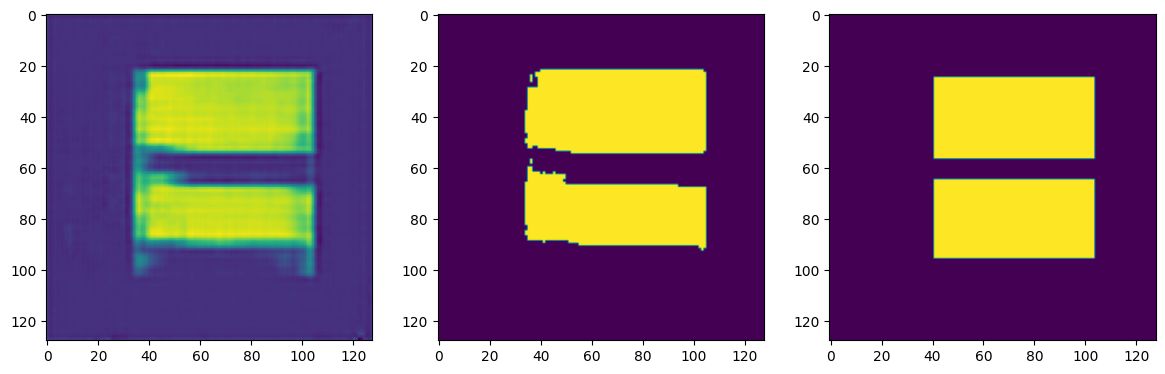

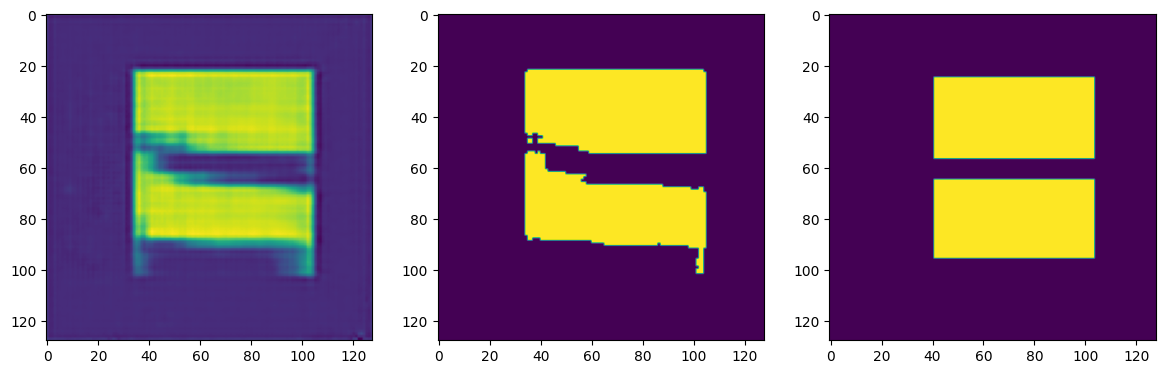

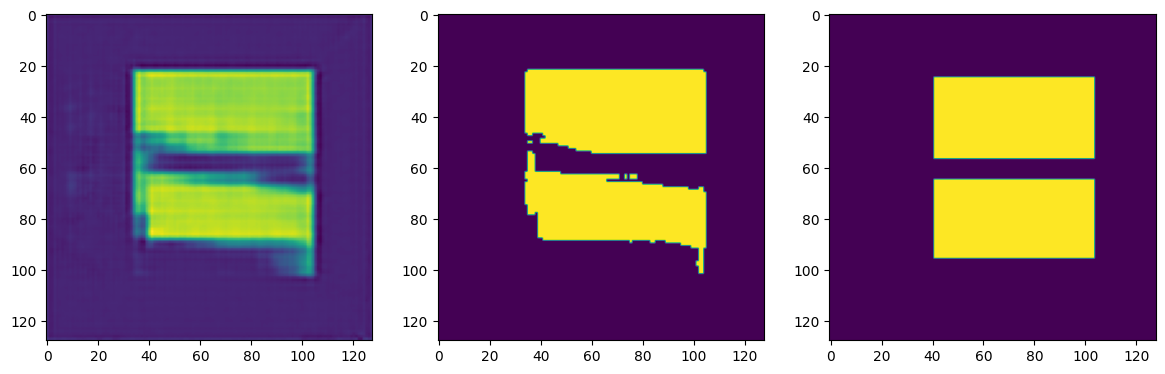

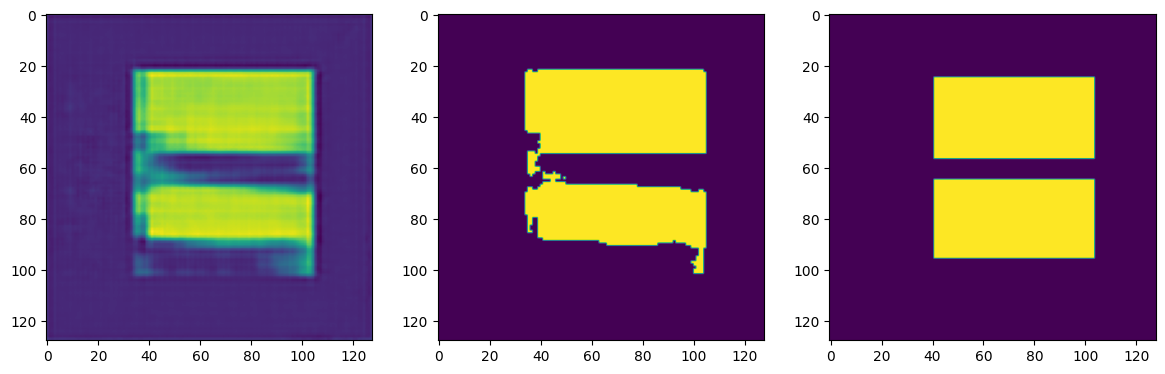

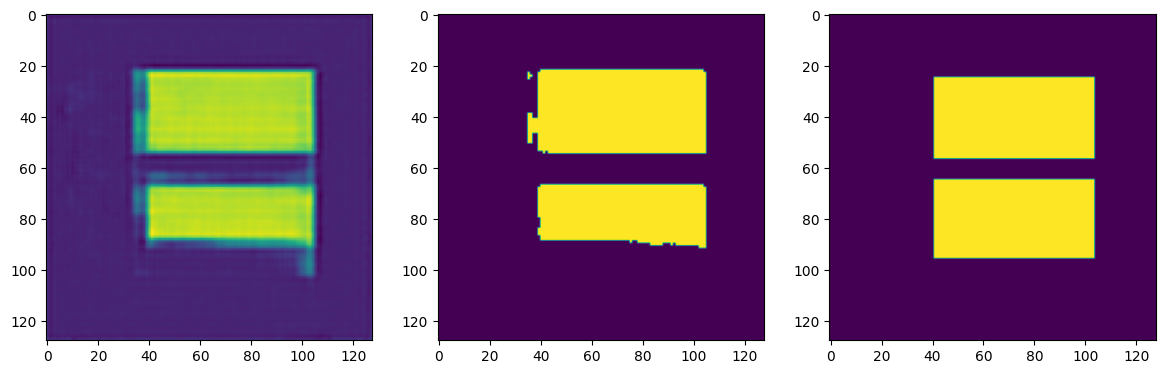

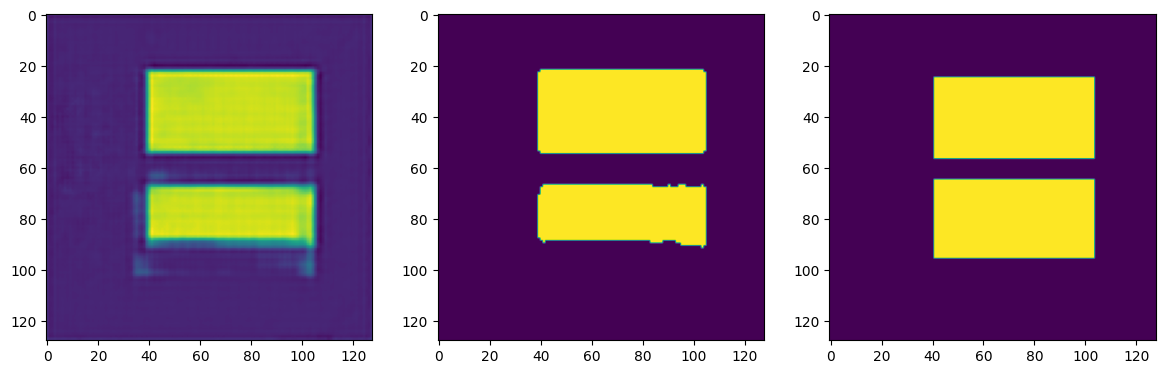

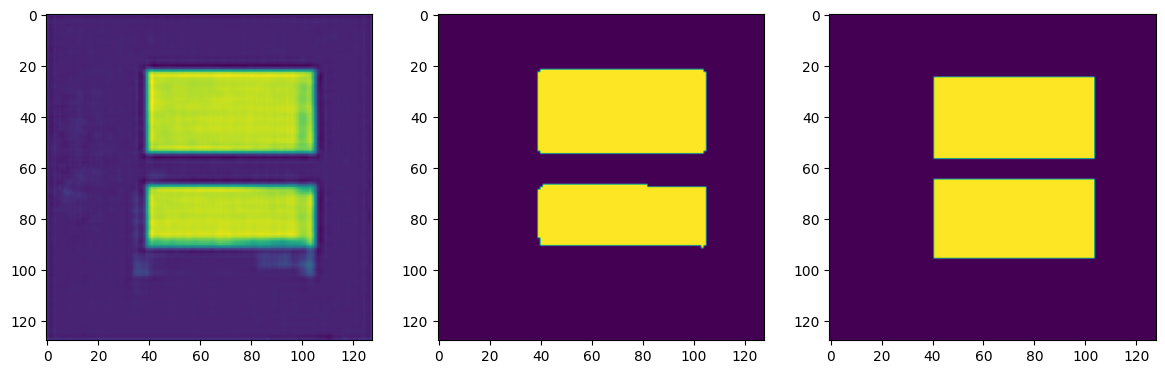

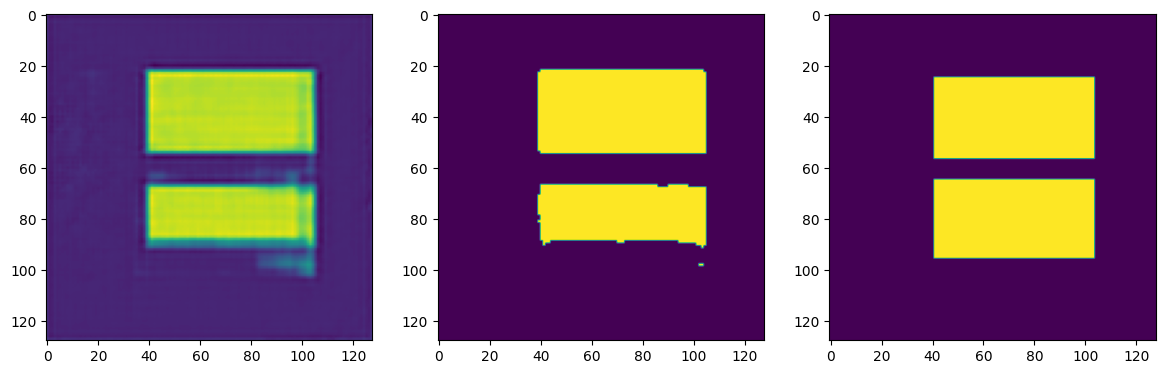

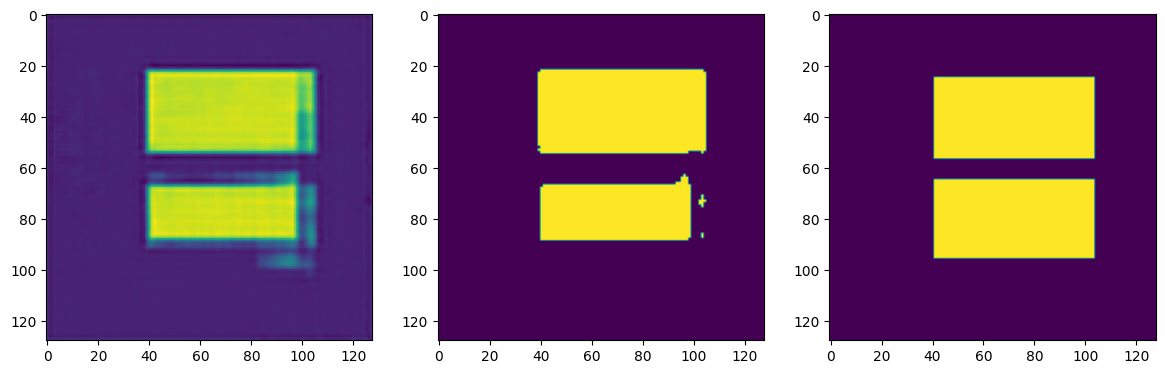

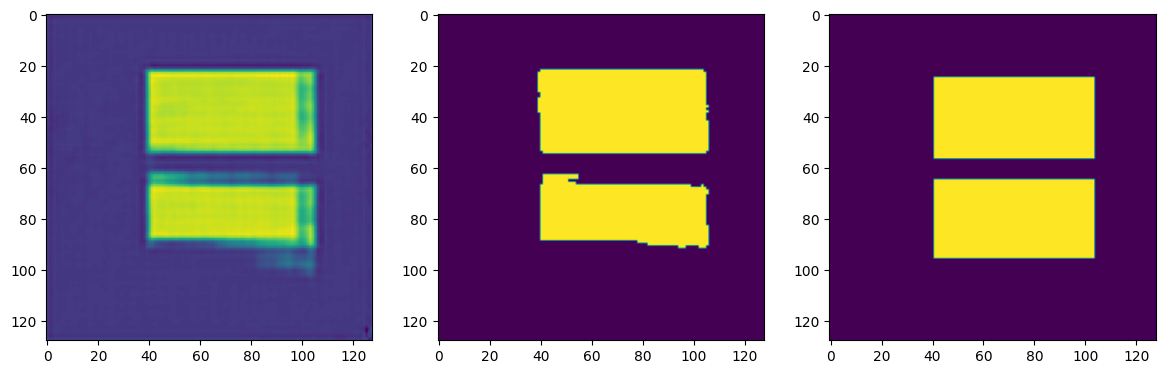

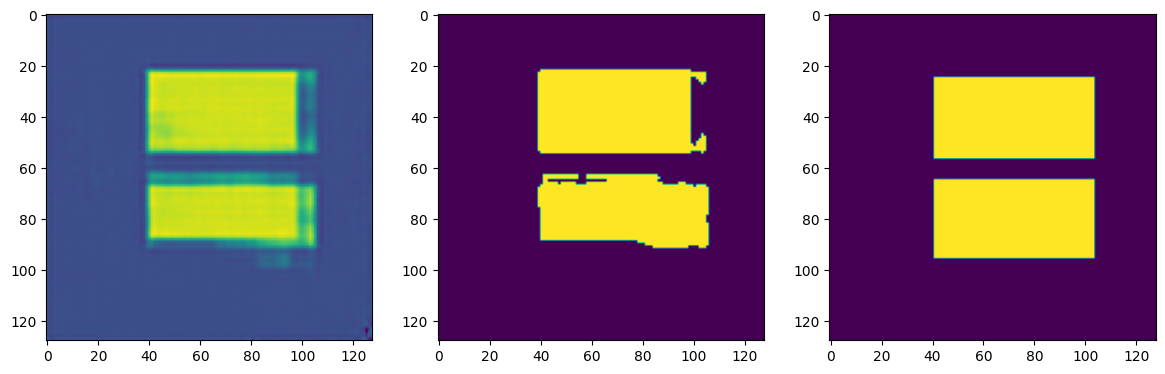

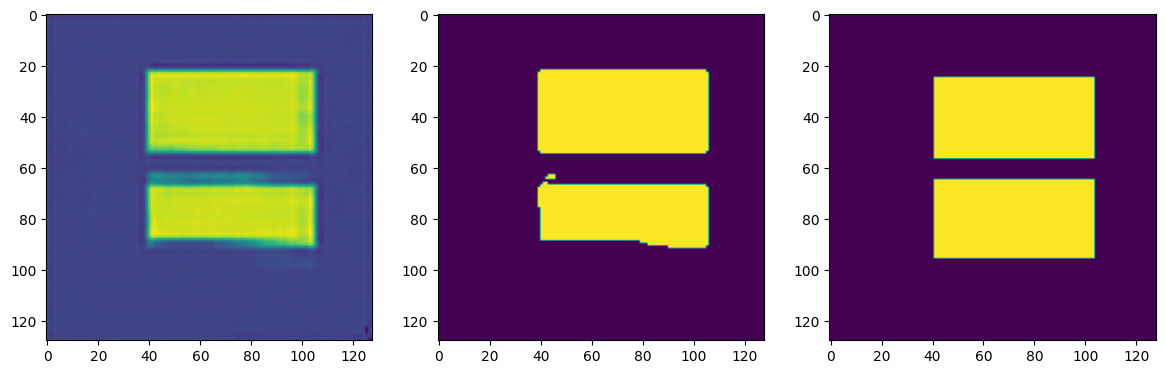

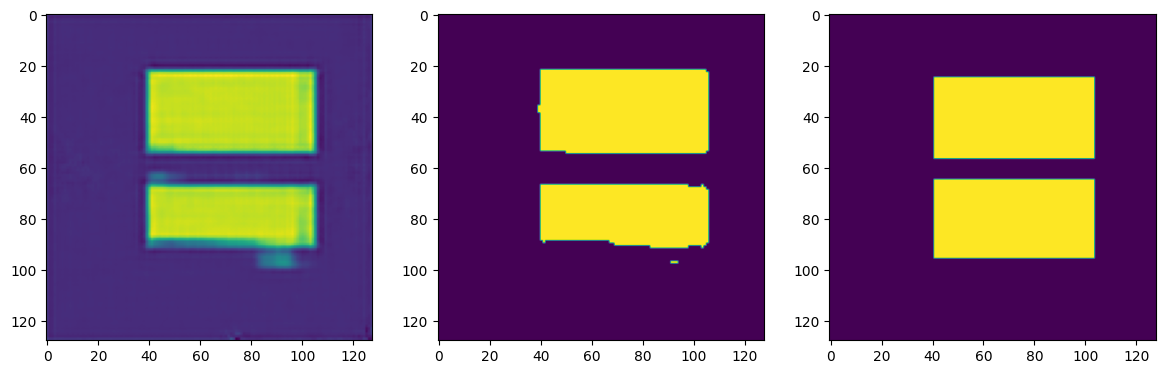

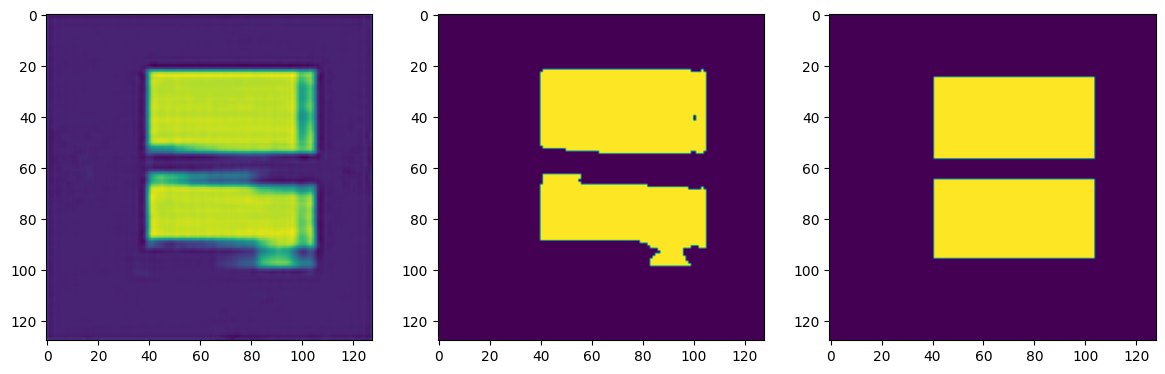

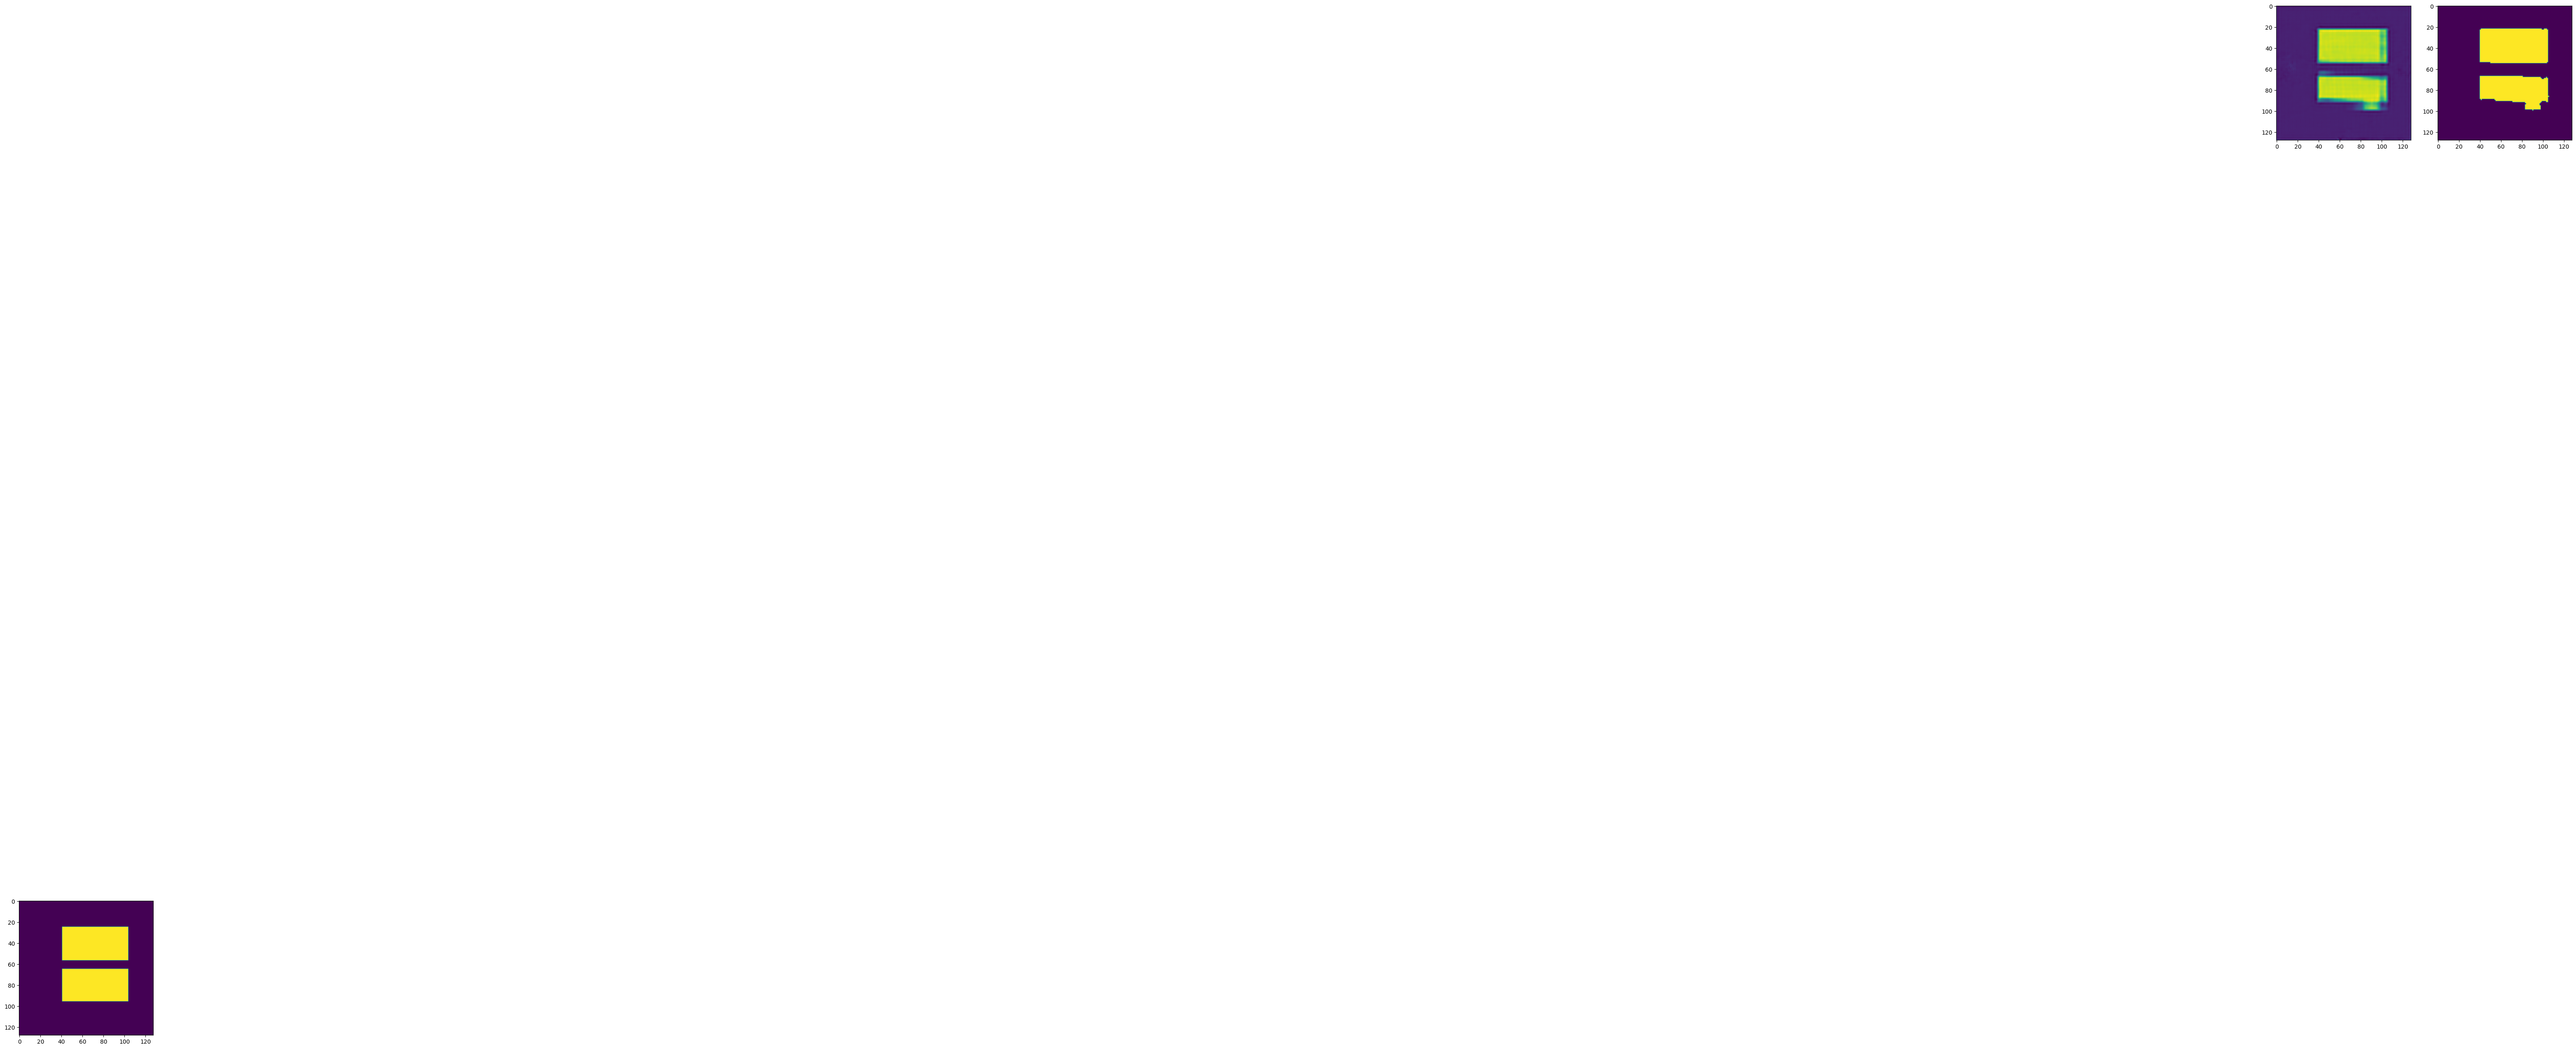

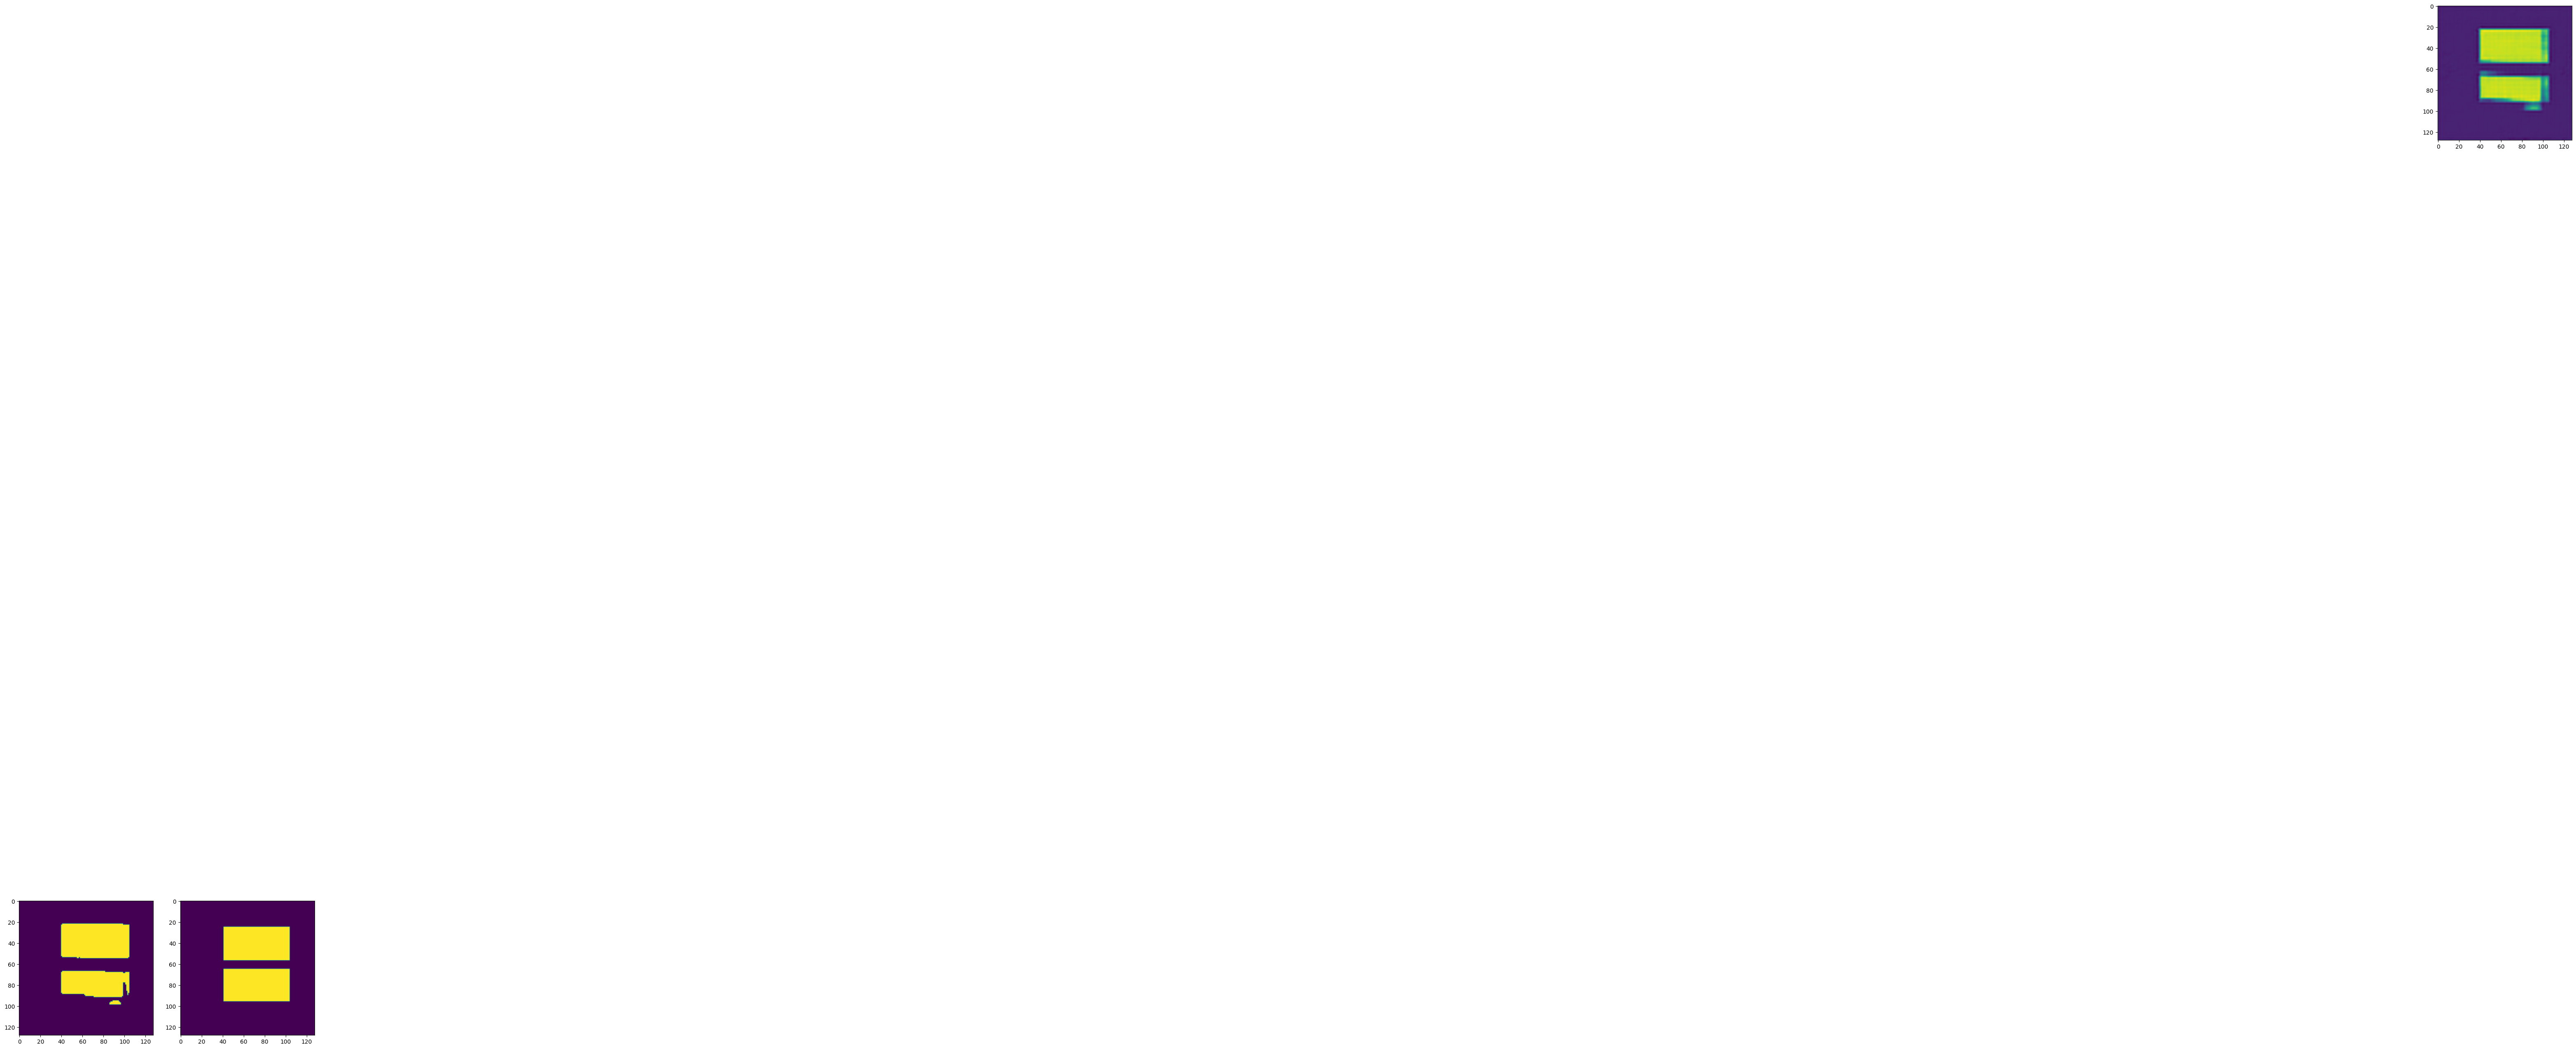

In [94]:
print(torch.min(test_masks[0]))
print(torch.min(test_masks[1]))

for idx in range(16):
    plt.figure(figsize=(80, 80))
    plt.subplot(3, 16, idx+1)
    plt.imshow(test_masks[idx].numpy()[0])
    
    plt.subplot(3, 16, idx+2)
    plt.imshow(thresholded_masks[idx][0])

    plt.subplot(3, 16, idx+3)
    plt.imshow(y_test[idx])
plt.show()